# PyTorch : Control Flow and Weight Sharing

동적 그래프와 가중치 공유의 예로, 매우 이상한 모델을 구현해보자: 

각각의 순전파 단계에서 많은 은닉 계층을 갖는 완전히 연결(Fully-connected)된 ReLU 신경망이 무작위로 1 ~ 4 사이의 숫자를 선택하고, 동일한 가중치를 여러 번 재사용하여 가장 안쪽(Innermost)에 있는 은닉 계층들을 계산합니다.

이 모델에서는 반복문을 구현하기 위해 일반적인 Python 제어 흐름을 사용하고, 순전파 단계를 정의할 때 단지 동일한 모듈을 여러번 재사용함으로써 내부(innermost) 계층들 간의 가중치 공유를 구현할 수 있습니다.

In [0]:
import torch
import random
import matplotlib.pyplot as plt 
% matplotlib inline

In [0]:
class DynamicNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(DynamicNet, self).__init__()
    self.input = torch.nn.Linear(D_in, H)
    self.middle = torch.nn.Linear(H, H)
    self.output = torch.nn.Linear(H, D_out)
    
  def forward(self, x):
    """
        모델의 순전파 단계에서, 무작위로 0, 1, 2 또는 3 중에 하나를 선택하고
        은닉 계층 표현(representation)을 계산하기 위해 여러번 사용한 middle_linear
        모듈을 재사용합니다.

        각 순전파 단계에서 동적 연산 그래프를 구성하기 때문에, 모델의 순전파 단계를
        정의할 때 반복문이나 조건문과 같이 일반적인 Python 제어 흐름 연산자를 사용할
        수 있습니다.

        여기에서 연산 그래프를 정의할 때 동일한 모듈을 여러번 재사용하는 것이
        완벽하게 안전하다는 것을 알 수 있습니다. 이것이 각 모듈을 한 번만 사용하는
        Lua Torch보다 크게 개선된 부분입니다.
        """
    
    h_relu = self.input(x).clamp(min=0)
    for _ in range(random.randint(0, 3)):
      h_relu = self.middle(h_relu).clamp(min=0)
    y_pred = self.output(h_relu)
    
    return y_pred

In [0]:
N, D_in, H, D_out = 128, 1000, 100, 10

In [0]:
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [18]:
model = DynamicNet(D_in, H, D_out)

print(model)

DynamicNet(
  (input): Linear(in_features=1000, out_features=100, bias=True)
  (middle): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
)


In [19]:
criterion = torch.nn.MSELoss(size_average=False)

# 손실함수와 Optimizer를 만듭니다. 이 이상한 모델을 순수한 확률적 경사 하강법
# (Stochastic Gradient Decent)으로 학습하는 것은 어려우므로, momentum을 사용합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
steps = []
loss_values = []

In [21]:
for t in range(500):
  y_pred = model(x)
  
  loss = criterion(y_pred, y)
  
  print(t, loss.item())
  
  steps.append(t)
  loss_values.append(loss.item())
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 1281.157470703125
1 1279.9249267578125
2 1342.7716064453125
3 1247.0172119140625
4 1275.6517333984375
5 1273.3812255859375
6 1272.837158203125
7 832.00244140625
8 1270.3394775390625
9 1229.734375
10 1207.583984375
11 570.024169921875
12 1263.9808349609375
13 1261.0643310546875
14 396.9237365722656
15 338.2886047363281
16 1024.88623046875
17 1242.971923828125
18 1209.8951416015625
19 1218.8167724609375
20 843.4841918945312
21 1106.8629150390625
22 1045.03955078125
23 965.9894409179688
24 349.96783447265625
25 815.615478515625
26 537.2307739257812
27 840.6239013671875
28 744.4998168945312
29 304.86505126953125
30 674.7953491210938
31 785.6873779296875
32 862.549560546875
33 450.04193115234375
34 512.908203125
35 351.0085144042969
36 635.1635131835938
37 258.88031005859375
38 326.4959411621094
39 562.279052734375
40 193.99952697753906
41 348.1356201171875
42 214.93165588378906
43 287.67584228515625
44 255.85963439941406
45 157.93617248535156
46 126.77056121826172
47 151.64389038085938
4

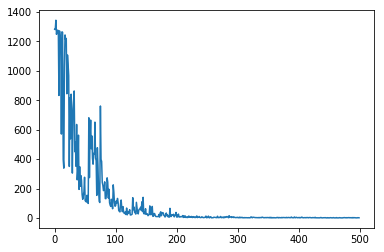

In [22]:
plt.plot(steps, loss_values)
plt.show()